In [1]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [2]:
include(string(@__DIR__, "/../Scripts/jupic.jl"))
using Plots

In [3]:
middle = "ST"
seq1 = "A" * middle * "B"
seq2 = "C" * middle * "D"

"CSTD"

In [4]:
num_cols = 512
encoding_size = 16

unique_letters = Set(seq1 * seq2)
encodings = Dict{Char, Array{Int, 1}}()
for ul in unique_letters
    encodings[ul] = randperm(num_cols)[1:encoding_size]
end

In [5]:
cells_per_col = encoding_size
tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = 32,
    initial_segments_per_cell = 0
)

TempMem
	512 Columns

In [6]:
epochs = 500
for i in 1:epochs
    seq = rand([seq1, seq2])
    for char in seq
        update!(tm, encodings[char])
    end
end

# Turn off learning mode
tm.ps.learning_enabled = false;

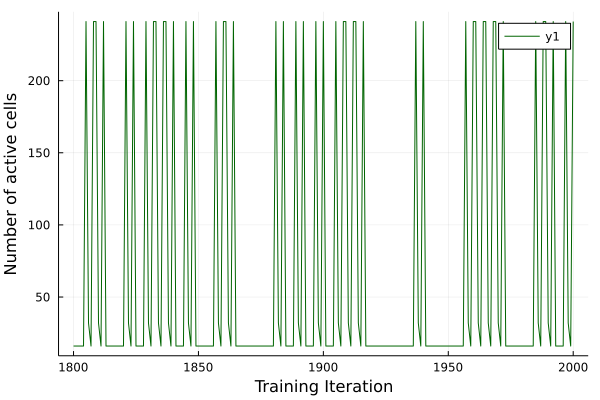

In [7]:
training_tsteps = tm.t
start = max(training_tsteps - 200, 1)
timesteps = start:training_tsteps
num_active_cells = [length(tm.active_cells[t]) for t in 1:tm.t][timesteps]
plot(timesteps, num_active_cells, color="darkgreen")
xlabel!("Training Iteration")
ylabel!("Number of active cells")

In [8]:
function sequence_accuracy_plot(tm, encodings, seq, incorrect_seq)
    num_predicted_cols = []
    overlap_w_correct_letter = []
    overlap_w_incorrect_letter = []

    for (char, wrong_char) in zip(seq, incorrect_seq)
        pred_enc = predicted_columns(tm)
        enc = encodings[char]
        wrong_enc = encodings[wrong_char]
        push!(num_predicted_cols, length(pred_enc))
        push!(overlap_w_correct_letter, length(intersect(pred_enc, enc)))
        push!(overlap_w_incorrect_letter, length(intersect(pred_enc, wrong_enc)))
        update!(tm, enc)
    end
    plot(legend=:outertopright, size=(800, 400))
    plot!(num_predicted_cols, label="Number of active columns")
    plot!(overlap_w_correct_letter, label="Overlap with correct encoding")
    plot!(overlap_w_incorrect_letter, label="Overlap with incorrect encoding")
    xticks!(1:length(seq), [string(c) for c in seq])
    ylabel!("Columns")
    xlabel!("Correct Symbol")
end

sequence_accuracy_plot (generic function with 1 method)

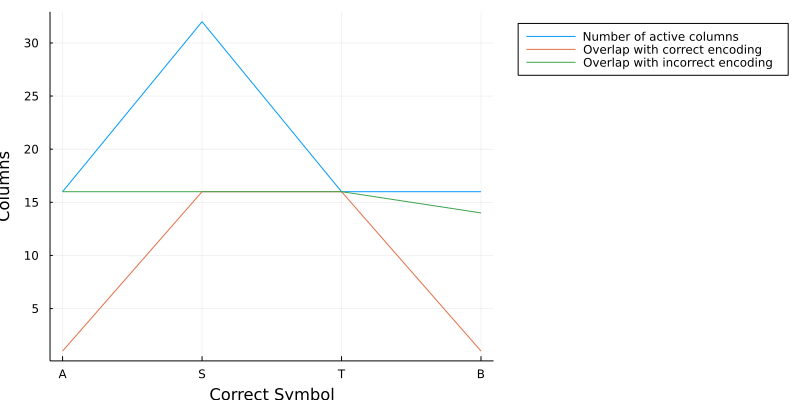

In [9]:
sequence_accuracy_plot(tm, encodings, seq1, seq2)

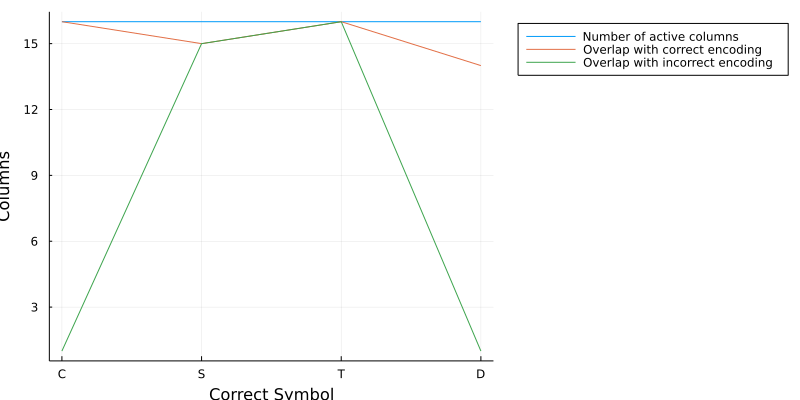

In [10]:
sequence_accuracy_plot(tm, encodings, seq2, seq1)

### Synapse Generation

In [11]:
num_synapses(s::Segment) = length(s.synapses)
num_synapses(c::Cell) = sum(num_synapses.(c.segments))
num_synapses(c::Column) = sum(num_synapses.(c.cells))
num_synapses(tm, col_idxs) = sum([num_synapses(tm.columns[i]) for i in col_idxs])

function num_synapses_from(tm, col_idxs)
    all_cells = union([tm.columns[i].cells for i in col_idxs]...)
    tot = 0
    for seg in tm.segments
        for syn in seg.synapses
            if syn.presynaptic_cell in all_cells
                tot += 1
            end
        end
    end
    return tot
end

num_synapses_from (generic function with 1 method)

In [12]:
cells_per_col = encoding_size
tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = 32,
    initial_segments_per_cell = 0
)

TempMem
	512 Columns

In [13]:
# Make an encoding of all unused columns
unused_cols = setdiff(1:num_cols, values(encodings)...)
encodings['!'] = unused_cols
push!(unique_letters, '!')

training_seq = ""
syn_to_char = Dict(ul => Int[] for ul in unique_letters)
syn_from_char = Dict(ul => Int[] for ul in unique_letters)

epochs = 25
for i in 1:epochs
    seq = rand([seq1, seq2])
    training_seq *= seq
    for char in seq
        update!(tm, encodings[char])
        for ul in unique_letters
            enc = encodings[ul]
            try
                push!(syn_to_char[ul], num_synapses(tm, enc))
                push!(syn_from_char[ul], num_synapses_from(tm, enc))
            catch e
                println("ul: $ul")
                println("num_synapses: $(num_synapses(tm, enc))")
                println("num_synapses_from: $(num_synapses_from(tm, enc))")
                println("syn_to_char[ul]: $(syn_to_char[ul])")
            end
                 
        end
    end
end

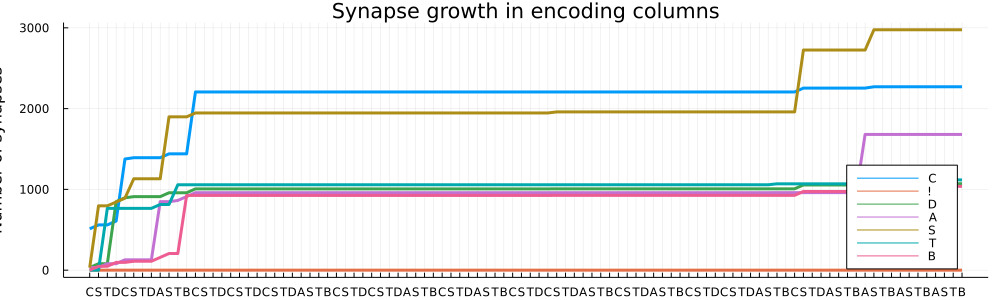

In [14]:
p1 = plot(legend=:bottomright, size=(1000, 300))

for ul in unique_letters
    plot!(p1, syn_to_char[ul], label=ul, lw=3)
end

xticks!(p1, 1:tm.t, [string(c) for c in training_seq])
ylabel!("Number of synapses")
title!("Synapse growth in encoding columns")

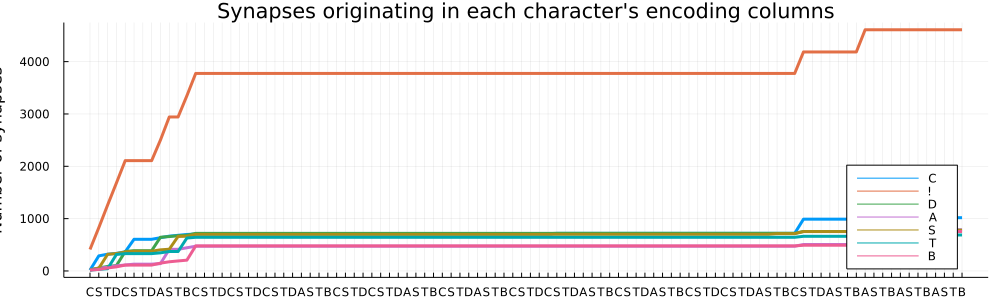

In [15]:
p2 = plot(legend=:bottomright, size=(1000, 300))

for ul in unique_letters
    plot!(p2, syn_from_char[ul], label=ul, lw=3)
end

xticks!(p2, 1:tm.t, [string(c) for c in training_seq])
ylabel!("Number of synapses")
title!("Synapses originating in each character's encoding columns")

### No Permanence

In [34]:
cells_per_col = encoding_size
tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = 32,
    initial_segments_per_cell = 0,
    initial_permanence = 1.0,
    permanence_increment = 0.0,
    permanence_decrement = 0.0,
    predicted_decrement = 0.0,
)

TempMem
	512 Columns

In [35]:
epochs = 2
for i in 1:epochs
    for seq in [seq1, seq2]
        # Reset winners in between. No new synapses
        tm.winner_cells[tm.t] = Set{Cell}()
        for char in seq
            update!(tm, encodings[char])
        end
    end
end

# Turn off learning mode
tm.ps.learning_enabled = false;

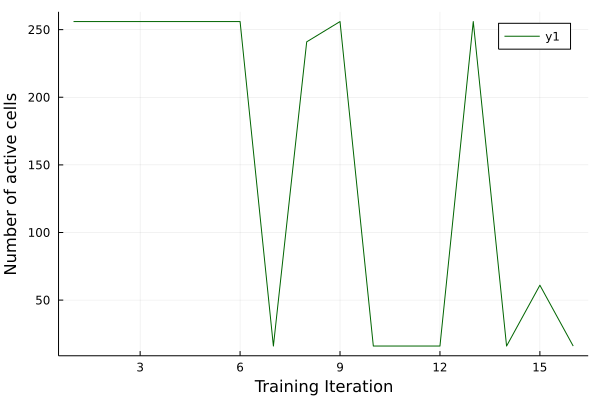

In [36]:
training_tsteps = tm.t
start = max(training_tsteps - 200, 1)
timesteps = start:training_tsteps
num_active_cells = [length(tm.active_cells[t]) for t in 1:tm.t][timesteps]
plot(timesteps, num_active_cells, color="darkgreen")
xlabel!("Training Iteration")
ylabel!("Number of active cells")

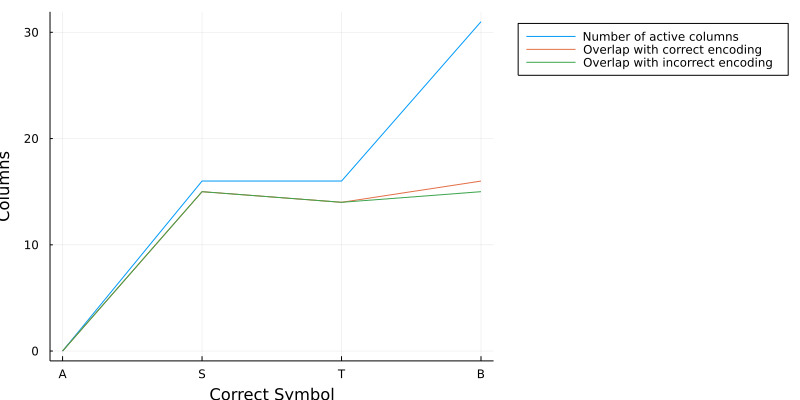

In [37]:
sequence_accuracy_plot(tm, encodings, seq1, seq2)

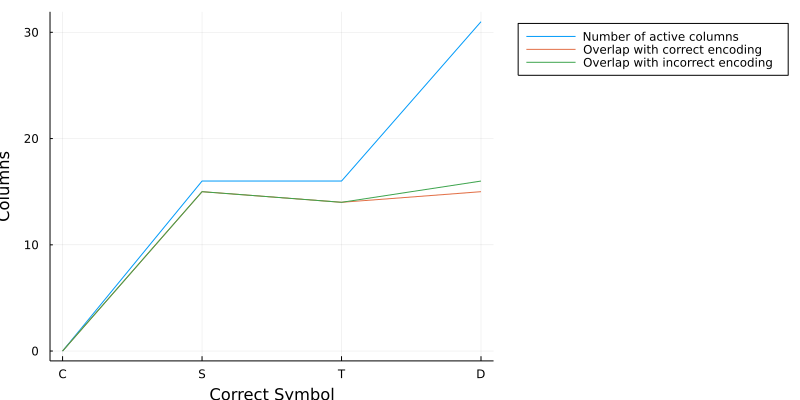

In [38]:
sequence_accuracy_plot(tm, encodings, seq2, seq1)

Long random sequence with the same character introduced in different places. 